In [1]:
import numpy as np
import center_algorithms as ca
import matplotlib.pyplot as plt

Tests with MNIST

#### To Do



In [2]:
'''
This function verifies that we found a local optimizer for
the sine median or maximum cosine problem.
It does this by checking 100 points around the optimizer.

Inputs: 
    optimizer- a numpy array that represente the suggested optimizer
    opf_fn- a string, 'sine' for sine median and 'cosine' for maximum cosine
    data- a list of numpy arrays representing points on grassmannians
Outputs:
    local optimizer- True if all checked points rsesult in objective function values
                        that are greater than the Sine Median problem or smaller than
                        the Maximum Cosine value
'''
def sanity_check(optimizer, opt_fn, data):
    
    n,r = optimizer.shape
    
    
    #objective function value for suggested optimizer
    sln_val = ca.calc_error_1_2(data, optimizer, opt_fn) 
    
    #stays true if optimizer is a local min
    local_optimizer = True

    #checking random points
    perturb_vals = []
    for i in range(100):
        
        #random points between -.5 and .5 times .01
        perturb = (np.random.rand(n,r)-5)*.00001 
        perturb_check = np.linalg.qr(perturb + optimizer)[0][:,:r]
        
        #check objective function value
        perturb_vals.append(ca.calc_error_1_2(data, perturb_check, opt_fn))

        if opt_fn == 'sine' or opt_fn == 'l2_med':
            if perturb_vals[i] < sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to minimizer')
        elif opt_fn == 'cosine':
            if perturb_vals[i] > sln_val:
                local_optimizer = False
#                 print(perturb_vals[i])
#                 print(sln_val)
#                 print('FlagIRLS did not converge to maximizer')

    # if not local_optimizer:
    #     print(sln_val)
    #     print(perturb_vals)
    return local_optimizer



# def sanity_check_old(optimizer, opt_fn, data):
#     '''
#     This function verifies that we found a local optimizer for
#     the sine median or maximum cosine problem.
#     It does this by checking 100 points around the optimizer.

#     Inputs: 
#         optimizer- a numpy array that represente the suggested optimizer
#         opf_fn- a string, 'sine' for sine median and 'cosine' for maximum cosine
#         data- a list of numpy arrays representing points on grassmannians
#     Outputs:
#         local optimizer- True if all checked points result in objective function values
#                             that are greater than the Sine Median problem or smaller than
#                             the Maximum Cosine value
#     '''
    
#     n,r = optimizer.shape
    
    
#     #objective function value for suggested optimizer
#     sln_val = ca.calc_error_1_2(data, optimizer, opt_fn) 
    
#     #stays true if optimizer is a local min
#     local_optimizer = True

#     #checking random points
#     perturb_vals = []
#     for i in range(100):
        
#         #random points between -.5 and .5 times .01
#         perturb = (np.random.rand(n,r)-5)*.01 
#         perturb_check = np.linalg.qr(perturb + optimizer)[0][:,:r]
        
#         #check objective function value
#         perturb_vals.append(ca.calc_error_1_2(data, perturb_check, opt_fn))

#         if opt_fn == 'sine':
#             if perturb_vals[i] < sln_val:
#                 local_optimizer = False
# #                 print(perturb_vals[i])
# #                 print(sln_val)
# #                 print('FlagIRLS did not converge to minimizer')
#         elif opt_fn == 'cosine':
#             if perturb_vals[i] > sln_val:
#                 local_optimizer = False
# #                 print(perturb_vals[i])
# #                 print(sln_val)
# #                 print('FlagIRLS did not converge to maximizer')
#     return local_optimizer

In [3]:


def load_mnist_data(digits, sample_size=100, dset='train', shuffle = False):
    '''
    Shannon Stiverson's dataloader

    Inputs:
        digits- list or int for digits from MNIST to be samples
        sample_size - number of samples of that digit
        dset - 'train' or 'test' for sampling from the training or the test datasets
    Outputs:
        out_datamat - a numpy array of dimensions (784 x sample_size)
        datamat_labels - a list of labels of the sampled points
    '''

    if type(digits) == int:
        digits = [digits]

    if type(sample_size) == int:
        sample_size = [sample_size]*len(digits)

    if len(sample_size) != len(digits):
        print('Incorrect number of sample sizes given.')
        return [], []

    return_data = []
    return_labels = []

    for i in range(len(digits)):
        digit = digits[i]
        size = sample_size[i]
        digit_data = np.loadtxt('../MNIST/%s%i.csv' % (dset, digit), delimiter=',')
        if digit_data.shape[1] < size:
            print('Sample number for digit %i reduced to %i' % (digit, digit_data.shape[1]))
            return_data.append(digit_data)
            return_labels.append([digit]*digit_data.shape[1])
        else:
            if shuffle:
                idx = np.random.choice(np.arange(digit_data.shape[1]), size)
            else:
                idx = np.arange(size)
            return_data.append(digit_data[idx, :])
            return_labels.append([digit]*size)

    datamat = return_data[0]
    datamat_labels = return_labels[0]

    if len(digits) > 1:
        for i in range(1, len(digits)):
            datamat = np.vstack((datamat, return_data[i]))
            datamat_labels = np.hstack((datamat_labels, return_labels[i]))

    out_datamat = datamat.T
    
    return out_datamat, datamat_labels


In [4]:

def run_test(k, digit1, digit2, num_samples1, num_samples2,n_its,seed):
    '''
    calculates Flag Mean, Maximum Cosine and Sine Median for a dataset

    Inputs:
        k- int for Gr(k,784)
        digit1- int for first digit
        digit2- int for second digit
        num_samples1- int for number of samples of digit1s
        num_samples2- int for number of samples of digit2s
        n_its- integer for the number of iterations of FlagIRLS
        seed- int for numpy random initialization
    Outputs:
        flagmean- numpy array that represents Flag Mean of gr_list
        sin_median- numpy array that represents Sine Median of gr_list
        max_cosine- numpy array that represents Max Cosine of gr_list
        gr_list- dataset as subspaces in Gr(k,748)
    '''
    
    data_matrix1 = load_mnist_data(digit1, k*num_samples1, dset='train')[0]
    data_matrix2 = load_mnist_data(digit2, k*num_samples2, dset='train')[0]

    gr_list = []
    for i in range(num_samples1):
        #TODO: make sure we're taking more than one two
        if k==1:
            point = data_matrix1[:,i*k:(i+1)*k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix1[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])

    for i in range(num_samples2):
        if k==1:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(point/np.linalg.norm(point))
        else:
            point = data_matrix2[:,i*k:(i+1)*k]
            gr_list.append(np.linalg.qr(point)[0][:,:k])
            
    
    flagmean = ca.flag_mean(gr_list, k, fast = False)
    print('Flag Mean finished')

    #calculate sine median
    sin_median, s_err = ca.irls_flag(gr_list, k, n_its, 'sine', opt_err = 'sine', fast = False, seed = seed)
    print('Chordal Median finished')

    #calculate maximum cosine
    max_cosine, c_err = ca.irls_flag(gr_list, k, n_its, 'cosine', opt_err = 'cosine', fast = False, seed = seed)
    print('Max Cos finished')
    
    #calculate l2 median
    #do it more than once if needed
    worked = False
    l2_seed = seed
    while not worked:
        l2_med, l2_err = ca.l2_median(gr_list, .1, k, 1000, l2_seed)
        worked = sanity_check(l2_med, 'l2_med', gr_list)
        print('l2 trial')
        l2_seed+=1
        
    print('L2 median finished')
    
    if k==1:
        #calculate geodesic median
        geodesic_median, g_err = ca.irls_flag(gr_list, k, n_its, 'geodesic', opt_err = 'geodesic', fast = False, seed = seed)
        print('Geodesic finished')

        return flagmean, sin_median, max_cosine, l2_med, geodesic_median, gr_list
    
    else:
        return flagmean, sin_median, max_cosine, l2_med, gr_list

In [5]:

def plot_results(title, Ys, plot_k, n2s, n5s):
    '''
    creates an image of the plot_k row of each Y in Ys

    Inputs:
        title- string for the plot title
        Ys- list of numpy arrays to be plotted
        plot_k - column to plot

    Outputs:
        none
    '''
    ii=0
    for Y in Ys:
        plt.figure()
        plt.title(title+' '+str(n2s[ii])+' twos and '+str(n5s[ii])+' fives')
        plt.imshow(Y[:,plot_k].reshape(28,28), cmap = 'gray')
        plt.axis('off')
        ii+=1

In [7]:
def calc_min_angle(X, Y):
    ''' 
    Calculates the minimum principle angle between subspaces [X] and [Y] where X,Y are numpy arrays 
    '''
    return np.arccos(np.linalg.svd(X.T @ Y)[1][-1])

# Beginning of Executible Code

## Gr(1,n)

In [8]:
k = 1 #Gr(k,n)
digit1 = 2
digit2 = 5
num_samples1 = 20 #number of samples of the 2 digit
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #for initialization
incr = 1 #samples 5s from 0 to num_samples2 in increments of incr

plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS

if num_samples1 % incr != 0:
    print('incr does not divide num_samples1 evenly!')

In [9]:

flagmeans = []
sin_medians = []
max_cosines = []
geo_medians = []
l2_meds = []
n2s  = []
n5s = []

for num_samples2 in range(0,num_samples1,incr):
    out = run_test(k,digit1,digit2,num_samples1,num_samples2,n_its,seed)
    flagmeans.append(out[0])
    sin_medians.append(out[1])
    max_cosines.append(out[2])
    l2_meds.append(out[3])
    if k == 1:
        geo_medians.append(out[4])
    n2s.append(num_samples1)
    n5s.append(num_samples2)
if k == 1:
    dataset = out[5]
else:
    dataset = out[4]

Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max

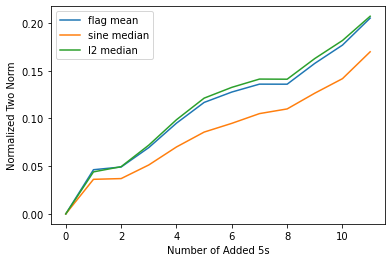

In [10]:
num_tests = num_samples1//incr
#differences from 0
flagmean_diffs = []
sin_medians_diffs = []
l2_meds_diffs = []
for ii in range(num_tests):
    flagmean_diffs.append(np.linalg.norm(flagmeans[ii] - flagmeans[0])/np.linalg.norm(flagmeans[0]))

    sin_medians_diffs.append(np.linalg.norm(sin_medians[ii] - sin_medians[0])/np.linalg.norm(sin_medians[0]))
    
    l2_meds_diffs.append(np.linalg.norm(l2_meds[ii] - l2_meds[0])/np.linalg.norm(l2_meds[0]))
    
xs = [i for i in range(0,12,incr)]
plt.plot(xs, flagmean_diffs[:12], label = 'flag mean')
plt.plot(xs, sin_medians_diffs[:12], label = 'sine median')
plt.plot(xs, l2_meds_diffs[:12], label = 'l2 median')

plt.xlabel('Number of Added 5s')
plt.ylabel('Normalized Two Norm')
plt.legend()


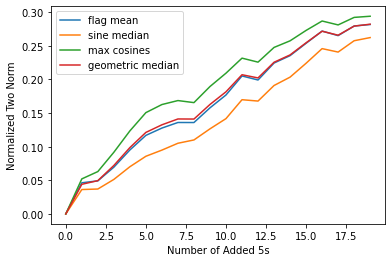

In [12]:
num_tests = num_samples1//incr
#differences from 0
flagmean_diffs = []
sin_medians_diffs = []
max_cosines_diffs = []
geo_medians_diffs = []
for ii in range(num_tests):
    flagmean_diffs.append(np.linalg.norm(flagmeans[ii] - flagmeans[0])/np.linalg.norm(flagmeans[0]))

    sin_medians_diffs.append(np.linalg.norm(sin_medians[ii] - sin_medians[0])/np.linalg.norm(sin_medians[0]))
    
    max_cosines_diffs.append(np.linalg.norm(max_cosines[ii] - max_cosines[0])/np.linalg.norm(max_cosines[0]))
    
    
    geo_medians_diffs.append(np.linalg.norm(geo_medians[ii] - geo_medians[0])/np.linalg.norm(geo_medians[0]))

xs = [i for i in range(0,num_samples1,incr)]
plt.plot(xs, flagmean_diffs, label = 'flag mean')
plt.plot(xs, sin_medians_diffs, label = 'sine median')
plt.plot(xs, max_cosines_diffs, label = 'max cosines')
plt.plot(xs, geo_medians_diffs, label = 'geometric median')
plt.xlabel('Number of Added 5s')
plt.ylabel('Normalized Two Norm')
plt.legend()


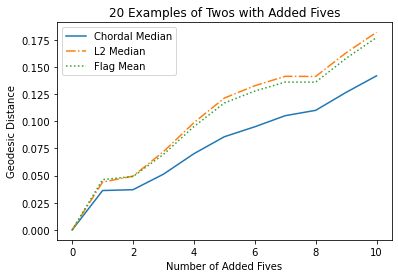

In [13]:
num_tests = num_samples1//incr
#differences from 0
flagmean_diffs = []
sin_medians_diffs = []
l2_meds_diffs = []
for ii in range(num_tests):
#     print(ca.calc_error_1_2([flagmeans[ii]],flagmeans[0],'geodesic'))
    flagmean_diffs.append(ca.calc_error_1_2([flagmeans[ii]],flagmeans[0],'geodesic'))

    sin_medians_diffs.append(ca.calc_error_1_2([sin_medians[ii]],sin_medians[0],'geodesic'))
    
    l2_meds_diffs.append(ca.calc_error_1_2([l2_meds[ii]],l2_meds[0],'geodesic'))
    

xs = [i for i in range(0,11,incr)]

plt.plot(xs, sin_medians_diffs[:11], label = 'Chordal Median')
plt.plot(xs, l2_meds_diffs[:11], label = 'L2 Median', linestyle = 'dashdot')
plt.plot(xs, flagmean_diffs[:11], label = 'Flag Mean', linestyle = 'dotted')
plt.xticks([0,2,4,6,8,10])
plt.title(str(num_samples1)+' Examples of Twos with Added Fives')
plt.xlabel('Number of Added Fives')
plt.ylabel('Geodesic Distance')
plt.legend()


0.0
0.046302059726936066
0.04913879244697783
0.06950807203422185
0.09509702062251264
0.11685669796739048
0.1277442701373948
0.13604748117255241
0.13599085938790817
0.15786913995002905
0.1770678928014307
0.205483074961679
0.19944546358987847
0.22483402072141875
0.23588299043515862
0.2544130405416808
0.2727247121219146
0.26589023288911495
0.28033568990995517
0.2825721698813459


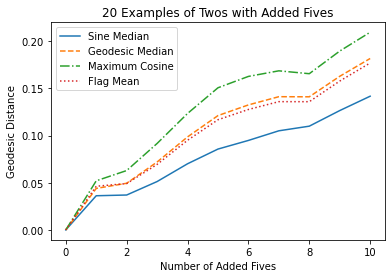

In [14]:
num_tests = num_samples1//incr
#differences from 0
flagmean_diffs = []
sin_medians_diffs = []
max_cosines_diffs = []
geo_medians_diffs = []
for ii in range(num_tests):
    print(ca.calc_error_1_2([flagmeans[ii]],flagmeans[0],'geodesic'))
    flagmean_diffs.append(ca.calc_error_1_2([flagmeans[ii]],flagmeans[0],'geodesic'))

    sin_medians_diffs.append(ca.calc_error_1_2([sin_medians[ii]],sin_medians[0],'geodesic'))
    
    max_cosines_diffs.append(ca.calc_error_1_2([max_cosines[ii]],max_cosines[0],'geodesic'))
    
    geo_medians_diffs.append(ca.calc_error_1_2([geo_medians[ii]],geo_medians[0],'geodesic'))

xs = [i for i in range(0,11,incr)]

plt.plot(xs, sin_medians_diffs[:11], label = 'Sine Median')
plt.plot(xs, geo_medians_diffs[:11], label = 'Geodesic Median', linestyle = 'dashed')
plt.plot(xs, max_cosines_diffs[:11], label = 'Maximum Cosine', linestyle = 'dashdot')
plt.plot(xs, flagmean_diffs[:11], label = 'Flag Mean', linestyle = 'dotted')
plt.xticks([0,2,4,6,8,10])
plt.title(str(num_samples1)+' Examples of Twos with Added Fives')
plt.xlabel('Number of Added Fives')
plt.ylabel('Geodesic Distance')
plt.legend()


/tmp/ipykernel_14724/2466647598.py:5: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.linalg.svd(X.T @ Y)[1][-1])


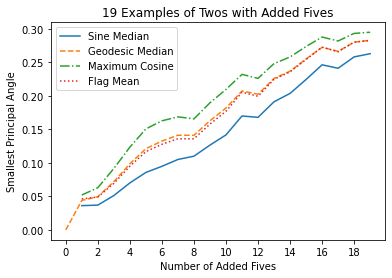

In [15]:
num_tests = num_samples1//incr
#differences from 0
flagmean_diffs = []
sin_medians_diffs = []
max_cosines_diffs = []
geo_medians_diffs = []
for ii in range(num_tests):
#     print(ca.calc_error_1_2([flagmeans[ii]],flagmeans[0],'geodesic'))
    flagmean_diffs.append(calc_min_angle(flagmeans[ii],flagmeans[0]))

    sin_medians_diffs.append(calc_min_angle(sin_medians[ii],sin_medians[0]))
    
    max_cosines_diffs.append(calc_min_angle(max_cosines[ii],max_cosines[0]))
    
    geo_medians_diffs.append(calc_min_angle(geo_medians[ii],geo_medians[0]))

xs = [i for i in range(0,num_samples1,incr)]

plt.plot(xs, sin_medians_diffs, label = 'Sine Median')
plt.plot(xs, geo_medians_diffs, label = 'Geodesic Median', linestyle = 'dashed')
plt.plot(xs, max_cosines_diffs, label = 'Maximum Cosine', linestyle = 'dashdot')
plt.plot(xs, flagmean_diffs, label = 'Flag Mean', linestyle = 'dotted')
plt.xticks([0,2,4,6,8,10,12,14,16,18])
plt.title(str(num_samples2)+' Examples of Twos with Added Fives')
plt.xlabel('Number of Added Fives')
plt.ylabel('Smallest Principal Angle')
plt.legend()


(-0.5, 27.5, 27.5, -0.5)

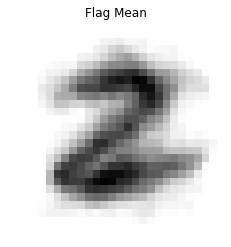

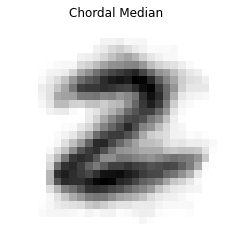

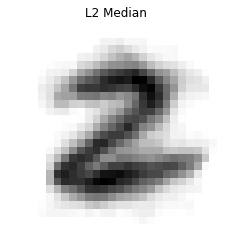

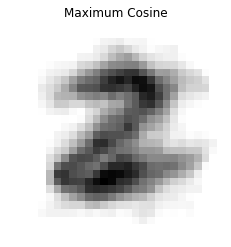

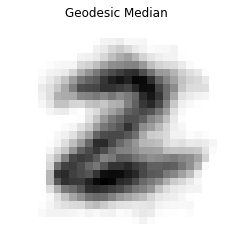

In [16]:
plt.figure()
plt.title('Flag Mean')
plt.imshow(flagmeans[7].reshape(28,28), cmap = 'gray')
plt.axis('off')

plt.figure()
plt.title('Chordal Median')
plt.imshow(sin_medians[7].reshape(28,28), cmap = 'gray')
plt.axis('off')

plt.figure()
plt.title('L2 Median')
plt.imshow(sin_medians[7].reshape(28,28), cmap = 'gray')
plt.axis('off')

plt.figure()
plt.title('Maximum Cosine')
plt.imshow(max_cosines[7].reshape(28,28), cmap = 'gray')
plt.axis('off')

plt.figure()
plt.title('Geodesic Median')
plt.imshow(geo_medians[7].reshape(28,28), cmap = 'gray')
plt.axis('off')

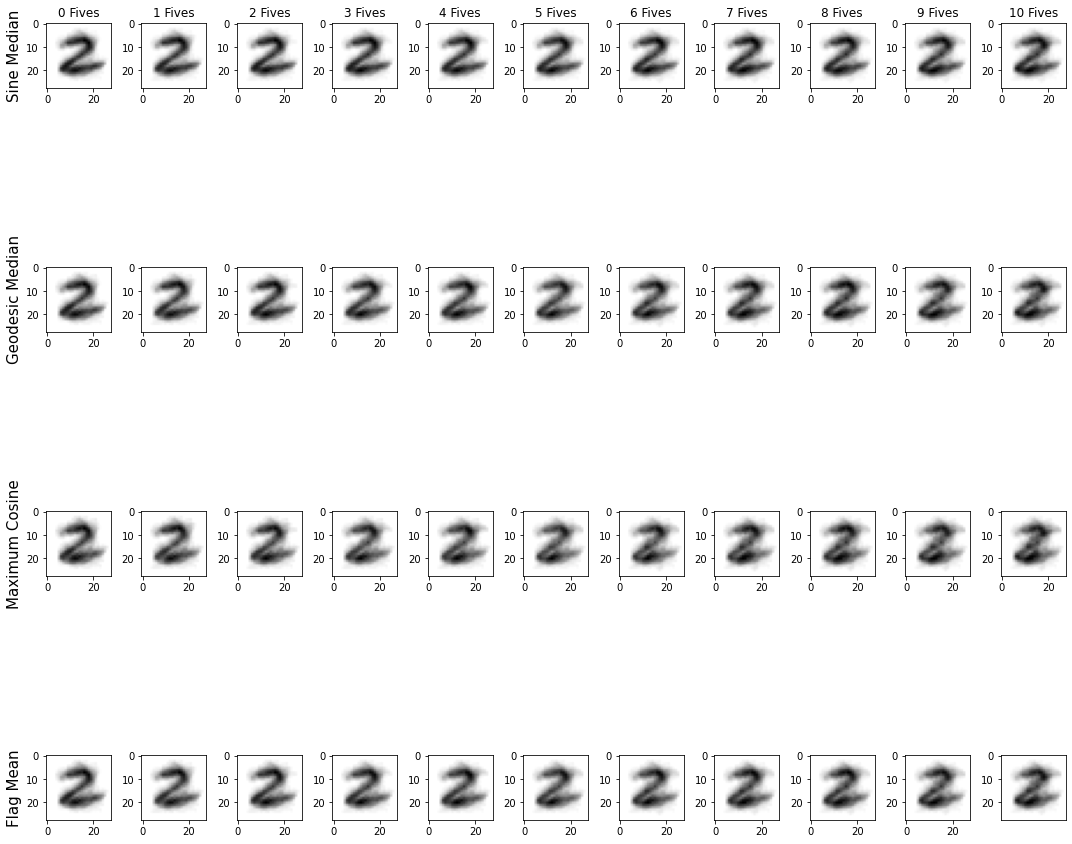

In [17]:
num_tests = num_samples1//incr
fig, axs = plt.subplots(4, 11, figsize=(15,15))

for ii in range(11):

    
#     axs[0,ii].set_title('Sine Median '+str(n2s[ii])+' twos , '+str(n5s[ii])+' fives')
    axs[0,ii].imshow(sin_medians[ii].reshape(28,28), cmap = 'gray')
#     axs[0,ii].axis('off')
    

    
#     axs[1,ii].set_title('Geodesic Median '+str(n2s[ii])+' twos, '+str(n5s[ii])+' fives')
    axs[1,ii].imshow(geo_medians[ii].reshape(28,28), cmap = 'gray')
#     axs[1,ii].axis('off')

#     axs[2,ii].set_title('Maximum Cosine '+str(n2s[ii])+' twos , '+str(n5s[ii])+' fives')
    axs[2,ii].imshow(max_cosines[ii].reshape(28,28), cmap = 'gray')
#     axs[2,ii].axis('off')

#     axs[3,ii].set_title('Flag Mean '+str(n2s[ii])+' twos, '+str(n5s[ii])+' fives')
    axs[3,ii].imshow(flagmeans[ii].reshape(28,28), cmap = 'gray')
#     axs[3,ii].axis('off')




plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelside=False) # labels along the bottom edge are off



cols = [str(ii)+' Fives' for ii in range(11)]
rows = ['Sine Median', 'Geodesic Median', 'Maximum Cosine', 'Flag Mean']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)    


for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size = 15)
    

    
fig.tight_layout()
plt.show()

Sine Median
Maximum Cosine
Geodesic Median
Flag Mean


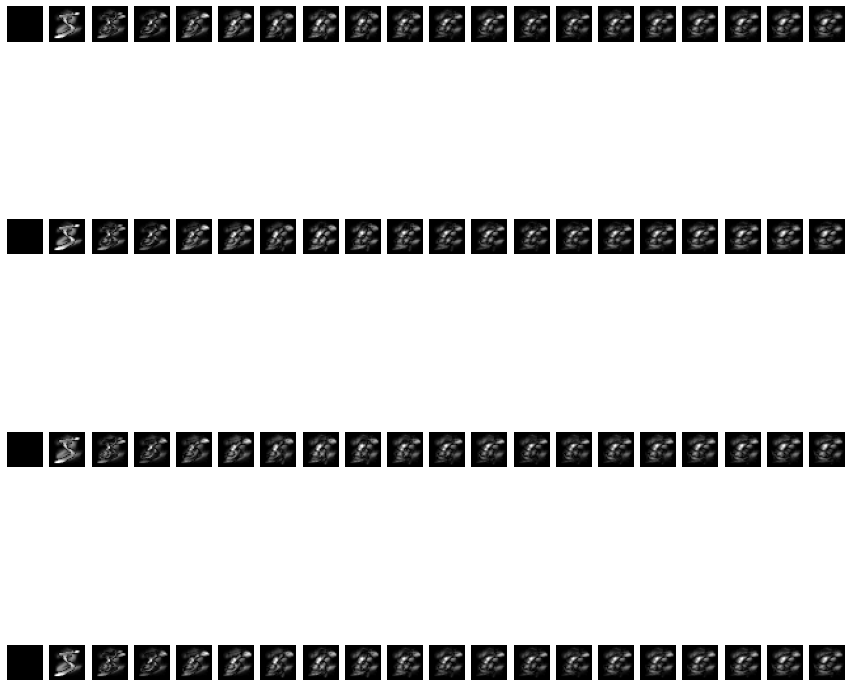

In [14]:
#differences from 0

num_tests = num_samples1//incr
fig, axs = plt.subplots(4, num_tests, figsize=(15,15))
for ii in range(num_tests):
#     axs[0,ii].set_title('Flag Mean '+str(n2s[ii])+' twos, '+str(n5s[ii])+' fives')
    temp = np.abs(flagmeans[ii] - flagmeans[0])
    axs[0,ii].imshow(temp.reshape(28,28), cmap = 'gray')
    axs[0,ii].axis('off')
    
#     axs[1,ii].set_title('Sine Median '+str(n2s[ii])+' twos , '+str(n5s[ii])+' fives')
    temp = np.abs(sin_medians[ii] - sin_medians[0])
    axs[1,ii].imshow(temp.reshape(28,28), cmap = 'gray')
    axs[1,ii].axis('off')
    
#     axs[2,ii].set_title('Maximum Cosine '+str(n2s[ii])+' twos , '+str(n5s[ii])+' fives')
    temp = np.abs(max_cosines[ii] - max_cosines[0])
    axs[2,ii].imshow(temp.reshape(28,28), cmap = 'gray')
    axs[2,ii].axis('off')
    
#     axs[3,ii].set_title('Geodesic Median '+str(n2s[ii])+' twos, '+str(n5s[ii])+' fives')
    temp = np.abs(geo_medians[ii] - geo_medians[0])
    axs[3,ii].imshow(temp.reshape(28,28), cmap = 'gray')
    axs[3,ii].axis('off')
print('Sine Median')
print('Maximum Cosine')
print('Geodesic Median')
print('Flag Mean')



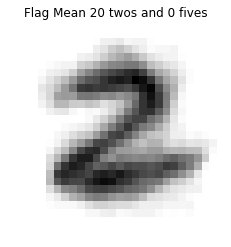

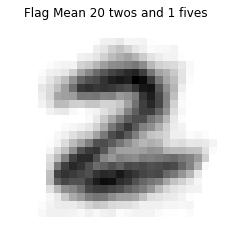

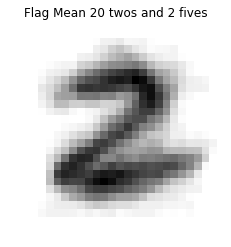

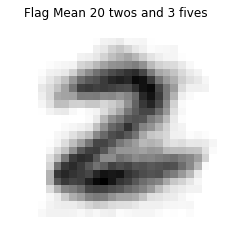

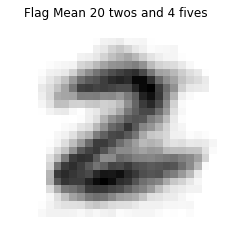

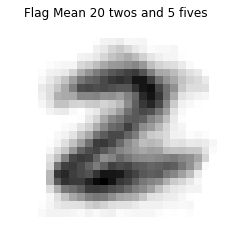

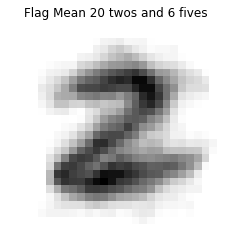

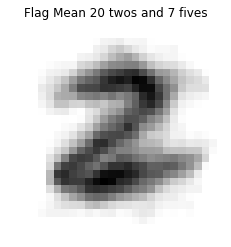

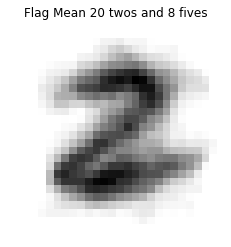

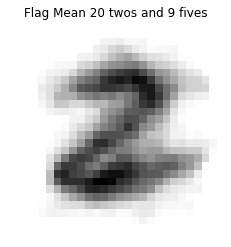

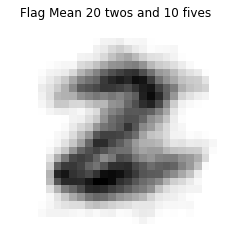

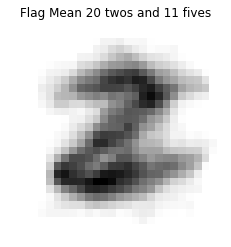

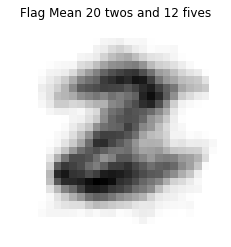

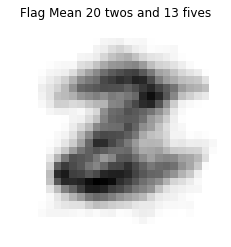

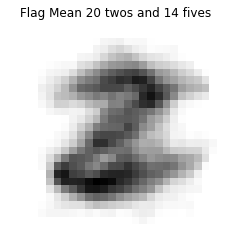

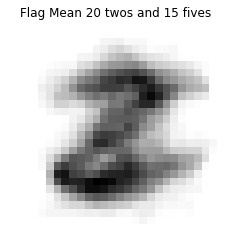

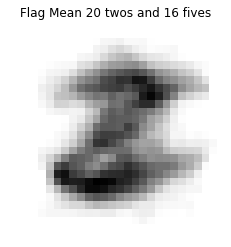

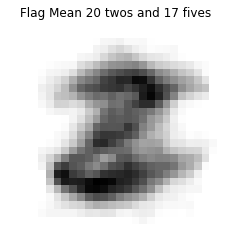

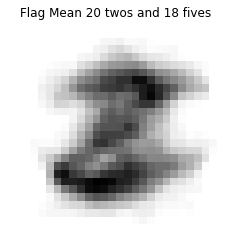

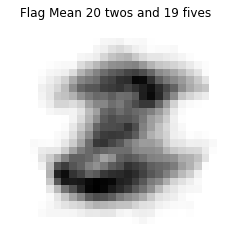

In [18]:
plot_results('Flag Mean', flagmeans, plot_k, n2s, n5s)

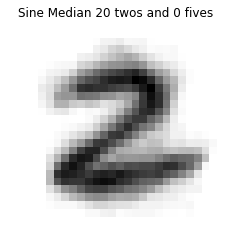

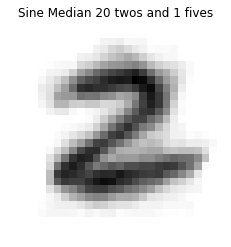

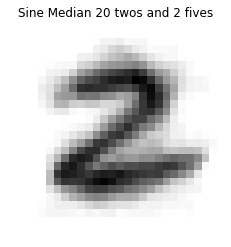

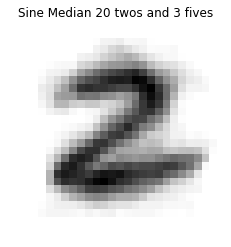

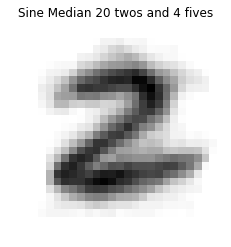

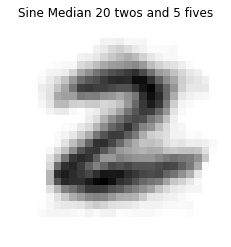

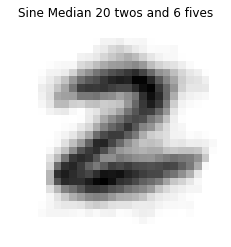

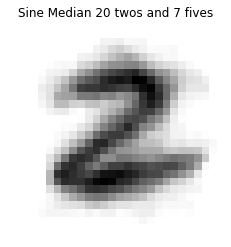

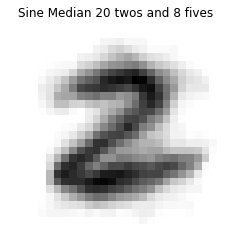

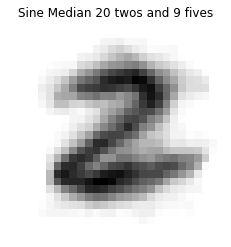

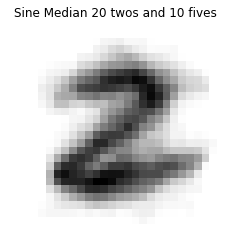

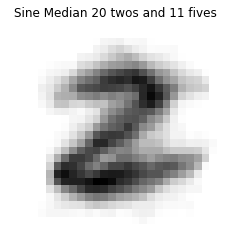

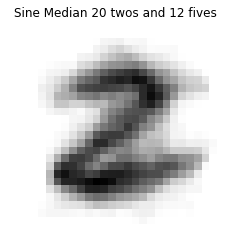

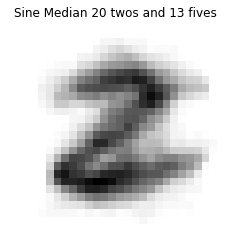

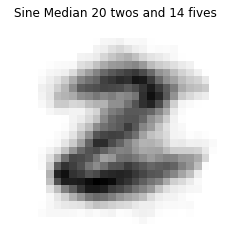

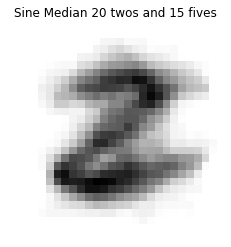

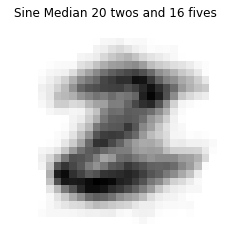

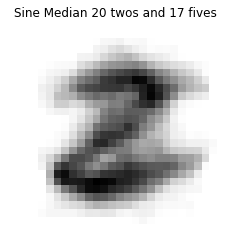

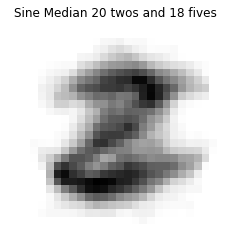

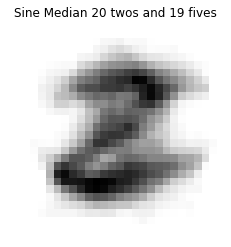

In [19]:
plot_results('Sine Median', sin_medians, plot_k, n2s, n5s)

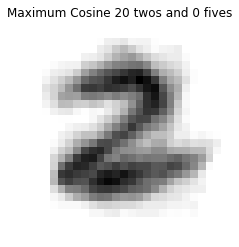

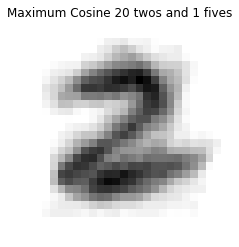

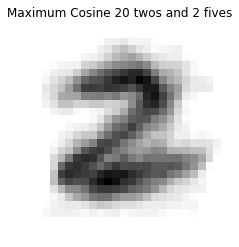

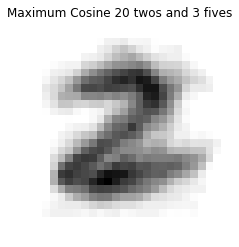

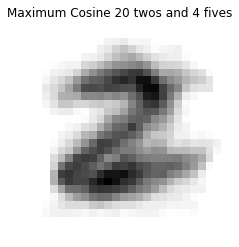

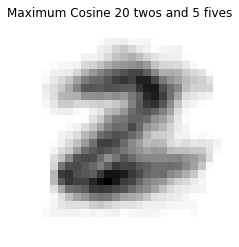

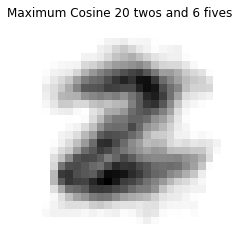

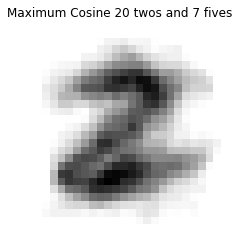

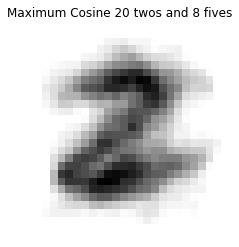

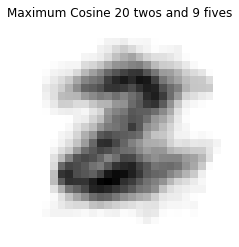

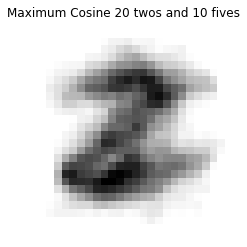

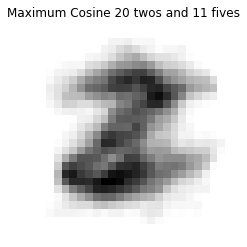

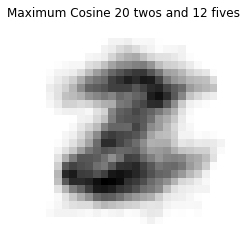

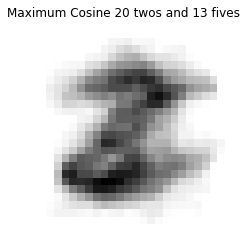

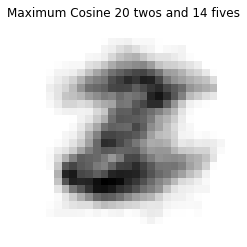

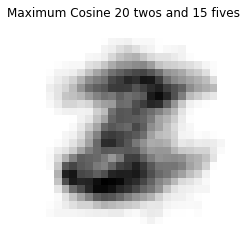

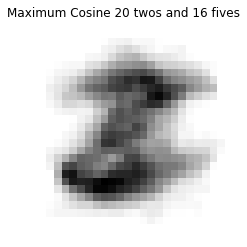

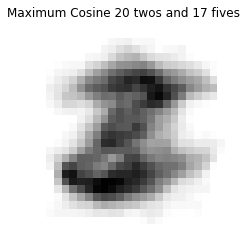

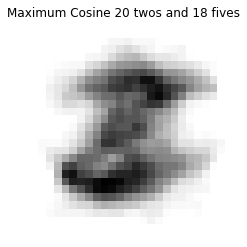

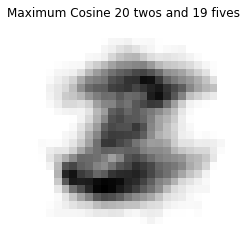

In [20]:
plot_results('Maximum Cosine', max_cosines, plot_k, n2s, n5s)

In [23]:
for sin_median in sin_medians:
    if not sanity_check(sin_median, 'sine', dataset):
        'Sine Median did not converge to optimizer'
for max_cosine in max_cosines:
    if not sanity_check(max_cosine, 'cosine', dataset):
        'Maximum Cosine did not converge to optimizer'
print('Check finished.')

Check finished.


## Run through classifier

In [8]:
import torch
import pandas

In [12]:



k = 1 #Gr(k,n)
digit1 = 1
digit2 = 9
num_samples1 = 20 #number of samples of the 2 digit
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #for initialization
incr = 1 #samples 5s from 0 to num_samples2 in increments of incr

plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS

if num_samples1 % incr != 0:
    print('incr does not divide num_samples2 evenly!')
    
    

Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max

/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.flatten.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/katrina/a/mankovic/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve t

Text(0.5, 0, 'Added Nines')

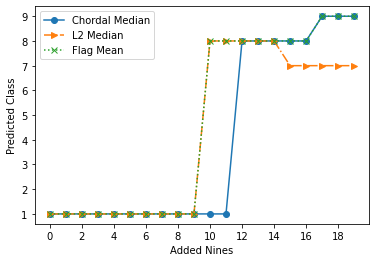

In [14]:

flagmeans = []
sin_medians = []
max_cosines = []
geo_medians = []
l2_meds = []
n2s  = []
n5s = []

for num_samples2 in range(0,num_samples1,incr):
    out = run_test(k,digit1, digit2, num_samples1,num_samples2,n_its,seed)
    flagmeans.append(out[0])
    sin_medians.append(out[1])
    max_cosines.append(out[2])
    l2_meds.append(out[3])
    if k == 1:
        geo_medians.append(out[4])
    n2s.append(num_samples1)
    n5s.append(num_samples2)
if k == 1:
    dataset = out[5]
else:
    dataset = out[4]
    
# model = torch.load('../MNIST_Classifier/raw_triangle_nn_3layer_lr_p1/model/model49.pth')
model = torch.load('/data4/mankovic/FRD-NN/experiments/mnist/raw/raw_triangle_nn_3layer_lr_p1/model/model49.pth')

model.eval()

predictions = pandas.DataFrame(columns = ['Added Nines', 'Sine Median', 'L2 Median', 'Flag Median'])

for i in range(20):
    point = sin_medians[i]
    s_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()

    point = flagmeans[i]
    f_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()
    
    point = l2_meds[i]
    l_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()
    
    predictions = predictions.append({'Added Nines': i,
                                      'Sine Median': s_prediction,
                                      'L2 Median':l_prediction,
                                      'Flag Median': f_prediction}, ignore_index = True)
    
plt.plot(predictions['Sine Median'], label = 'Chordal Median', linestyle = 'solid', marker = 'o')
plt.plot(predictions['L2 Median'], label = 'L2 Median', linestyle = 'dashdot', marker = '>')
plt.plot(predictions['Flag Median'], label = 'Flag Mean', linestyle = 'dotted', marker = 'x')
plt.legend()
plt.xticks([0,2,4,6,8,10,12,14,16,18])
plt.ylabel('Predicted Class')
plt.xlabel('Added Nines')

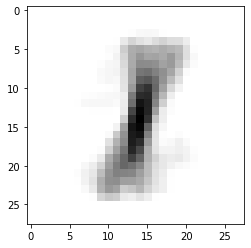

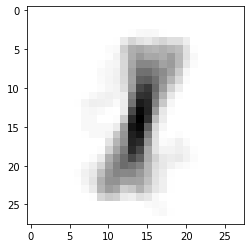

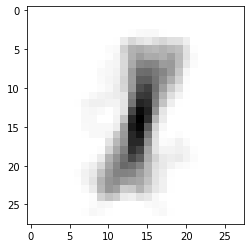

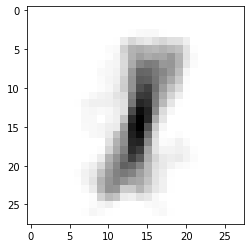

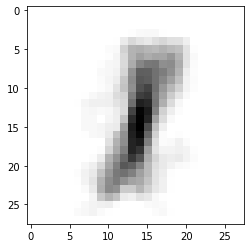

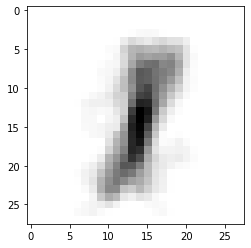

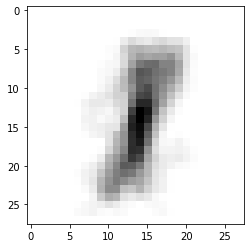

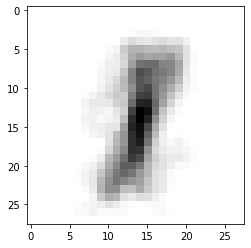

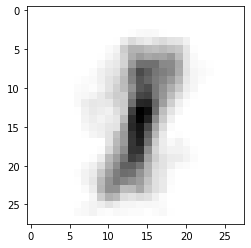

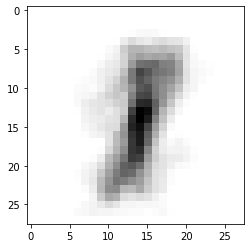

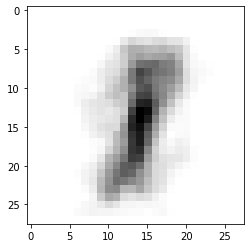

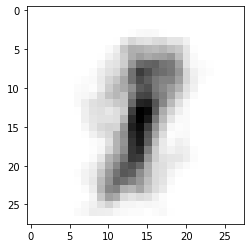

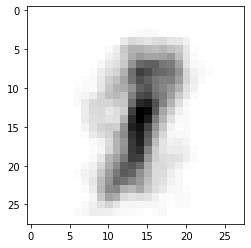

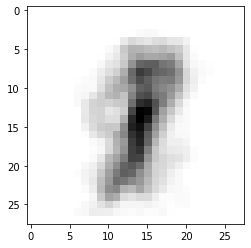

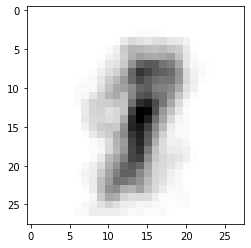

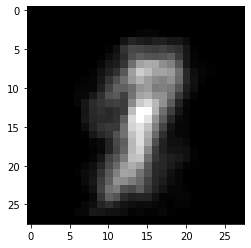

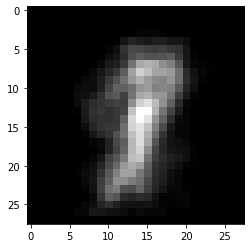

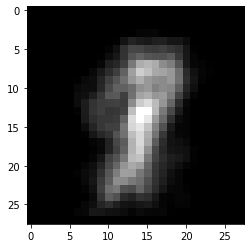

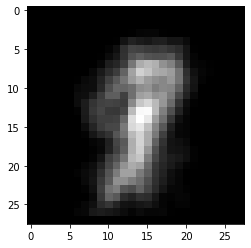

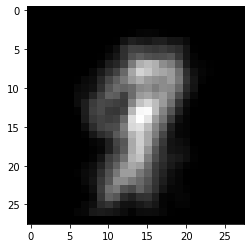

In [15]:
for im in l2_meds:
    plt.figure()
    plt.imshow(im.reshape((28,28)), cmap = 'gray')

In [26]:
len(sin_medians)

20

In [27]:
# predictions = pandas.DataFrame(columns = ['Added Nines', 'Sine Median', 'Geodesic Median', 'Flag Median', 'Maximum Cosine'])

# for i in range(20):
#     point = sin_medians[i]
#     s_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()
    
#     point = geo_medians[i]
#     g_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()

#     point = flagmeans[i]
#     f_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()
    
#     point = max_cosines[i]
#     c_prediction = torch.argmax(model(torch.tensor(point.T*-255).float())).item()
    
#     predictions = predictions.append({'Added Nines': i,
#                                       'Sine Median': s_prediction,
#                                       'Geodesic Median':g_prediction,
#                                       'Flag Median': f_prediction,
#                                       'Maximum Cosine': c_prediction}, ignore_index = True)

# plt.plot(predictions['Sine Median'], label = 'Sine Median', linestyle = 'solid', marker = 'o')
# plt.plot(predictions['Geodesic Median'], label = 'Geodesic Median', linestyle = 'dashdot', marker = '>')
# plt.plot(predictions['Maximum Cosine'], label = 'Maximum Cosine', linestyle = 'dashed', marker = '*')
# plt.plot(predictions['Flag Median'], label = 'Flag Mean', linestyle = 'dotted', marker = 'x')
# plt.legend()
# plt.xticks([0,2,4,6,8,10,12,14,16,18])
# plt.ylabel('Predicted Class')
# plt.xlabel('Added Nines')



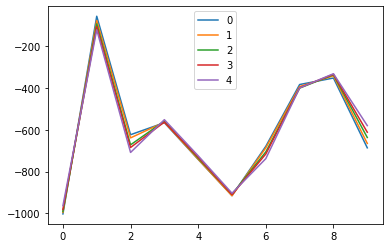

In [30]:
# for i in range(5):
#     point = sin_medians[i]
#     out = model(torch.tensor(point.T*-255).float())
#     plt.plot(np.arange(10),out.detach().cpu().numpy()[0,:], label = str(i))
    
# plt.legend()

Text(0.5, 0, 'Number')

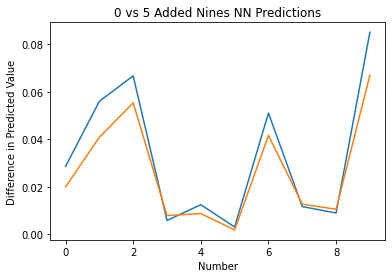

In [31]:
# point0 = max_cosines[0]
# point1 = max_cosines[5]
# out0 = model(torch.tensor(point0.T*-255).float())
# out1 = model(torch.tensor(point1.T*-255).float())
# out_cos = out0.detach().cpu().numpy()[0,:]/np.linalg.norm(out0.detach().cpu().numpy()[0,:]) - out1.detach().cpu().numpy()[0,:]/np.linalg.norm(out1.detach().cpu().numpy()[0,:])

# plt.plot(np.arange(10), np.abs(out_cos), label = str(i))

# point0 = sin_medians[0]
# point1 = sin_medians[5]
# out0 = model(torch.tensor(point0.T*-255).float())
# out1 = model(torch.tensor(point1.T*-255).float())



# out_sin = (out0.detach().cpu().numpy()[0,:]/np.linalg.norm(out0.detach().cpu().numpy()[0,:]) - out1.detach().cpu().numpy()[0,:]/np.linalg.norm(out1.detach().cpu().numpy()[0,:]))
# plt.plot(np.arange(10), np.abs(out_sin), label = str(i))
# plt.title('0 vs 5 Added Nines NN Predictions')
# plt.ylabel('Difference in Predicted Value')
# plt.xlabel('Number')

## Embeddings

In [19]:
from sklearn.manifold import MDS

In [35]:
def run_embedding_test(k, include_data = True):
    '''
    plots MDS embedding of exemplars and datasets with 20 examples of 7s and 0,1,2,...,19 examples of 6s
    
    Inputs: 
        k (integer) points on Gr(k,n)
    '''
    num_samples1 = 20 #number of samples of the 6 digit
    n_its = 20 #number of iterations for FlagIRLS
    seed = 1 #for initialization
    incr = 1 #samples 5s from 0 to num_samples2 in increments of incr
    plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS
    digit1 = 6
    digit2 = 7

    if num_samples1 % incr != 0:
        print('incr does not divide num_samples2 evenly!')
        
    
    flagmeans = []
    sin_medians = []
    max_cosines = []
    geo_medians = []
    l2_meds = []
    n2s  = []
    n5s = []

    for num_samples2 in range(0,num_samples1,incr):
        out = run_test(k,digit1, digit2, num_samples1,num_samples2,n_its,seed)
        flagmeans.append(out[0])
        sin_medians.append(out[1])
        max_cosines.append(out[2])
        l2_meds.append(out[3])
        if k == 1:
            geo_medians.append(out[4])
        n2s.append(num_samples1)
        n5s.append(num_samples2)
    if k == 1:
        dataset = out[5]
    else:
        dataset = out[4]

    dataset_and_averages = dataset + sin_medians+l2_meds+flagmeans

    n_all_pts = len(dataset_and_averages)

    Distances = np.zeros((n_all_pts, n_all_pts))

    for i in range(n_all_pts):
        for j in range(i+1, n_all_pts):
            if k == 1:
                cos = (dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])[0][0]
                if cos > 1:
                    cos = 1
                elif cos < 0:
                    cos = 0
                Distances[i,j] = np.arccos(np.sqrt(cos))
                Distances[j,i] = Distances[i,j].copy()
            else:
                cos = np.linalg.svd(dataset_and_averages[i].T @ dataset_and_averages[j])[1]
                sumcos = np.sum(np.arccos(cos)**2)
                if np.isnan(sumcos):
                    print(cos)
                    sumcos = 0
                Distances[i,j] = np.sqrt(sumcos)
    #             Distances[i,j] = k - np.trace(dataset_and_averages[i].T @ dataset_and_averages[j] @ dataset_and_averages[j].T @ dataset_and_averages[i])
                Distances[j,i] = Distances[i,j].copy()

    embedding = MDS(dissimilarity = 'precomputed', n_components = 2)
    transformed = embedding.fit_transform(Distances)

    for i in range(0,num_samples2+1,4):
        plt.figure()
        if include_data:
            plt.scatter(transformed[:num_samples1,0], transformed[:num_samples1,1], c = '.2', label = 'Sevens')
            if i > 0:
                plt.scatter(transformed[num_samples1:num_samples1+i,0], transformed[num_samples1:num_samples1+i,1], color = 'purple', marker = 'x', label = 'Sixes')
        plt.plot(transformed[num_samples1+num_samples2:num_samples1+num_samples2+i+1,0], transformed[num_samples1+num_samples2:num_samples1+num_samples2+i+1,1], c = 'blue', fillstyle = 'none', marker = '<', markevery = 4, label = 'Chordal Median')
        plt.plot(transformed[num_samples1+(num_samples2+1)*2-1:num_samples1+(num_samples2+1)*2-1+i+1,0], transformed[num_samples1+(num_samples2+1)*2-1:num_samples1+(num_samples2+1)*2-1+i+1,1], c = 'orange', linestyle = 'dashdot', fillstyle = 'none', marker = '<', markevery = 4, label = 'L2 Median')
        plt.plot(transformed[num_samples1+(num_samples2+1)*3-1:num_samples1+(num_samples2+1)*3-1+i+1,0], transformed[num_samples1+(num_samples2+1)*3-1:num_samples1+(num_samples2+1)*3-1+i+1,1], c = 'green', linestyle = 'dotted', fillstyle = 'none', marker = '<', markevery = 4, label = 'Flag Mean')
        if i == 8:
            plt.legend()

Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max

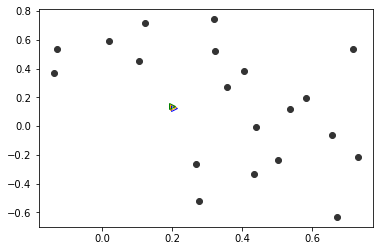

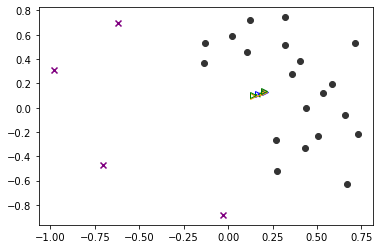

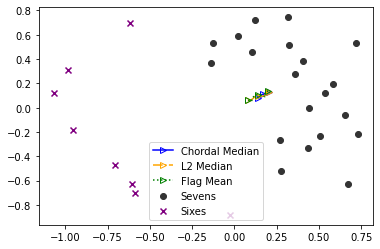

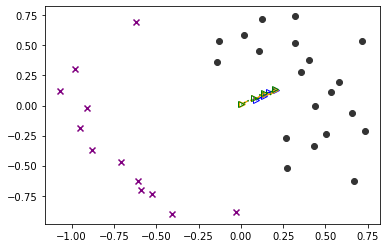

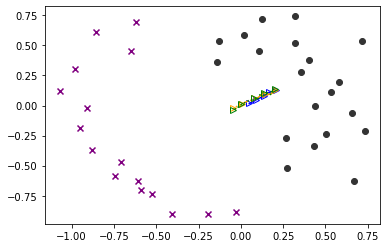

In [33]:
run_embedding_test(1)

Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Geodesic finished
Flag Mean finished
Chordal Median finished
Max

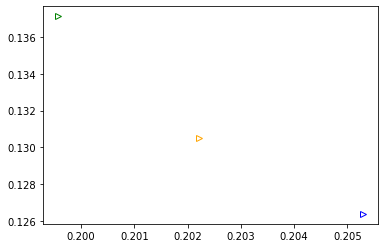

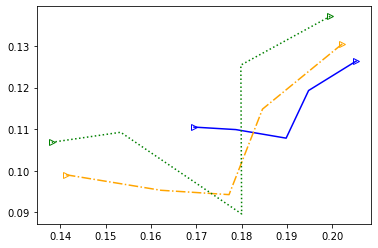

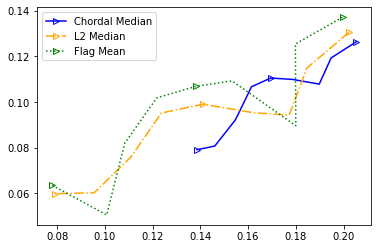

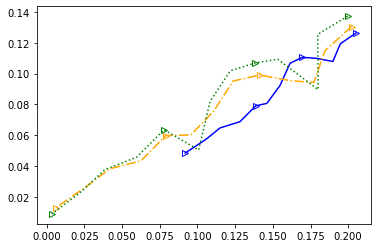

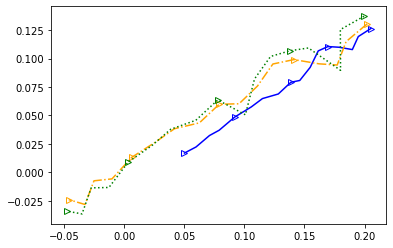

In [36]:
run_embedding_test(1, False)

In [34]:
run_embedding_test(4)

Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
L2 median finished
Flag Mean finished
Chordal Median finished
Max Cos finished
l2 trial
l2 trial
l2 trial
l2 trial
L2 median finished
Flag Mean finished
Chordal Median finished
Max Cos finished


KeyboardInterrupt: 

## Higher Dimensions of Exemplars

In [19]:
num_samples2 = 20 #number of samples of the 6 digit
n_its = 20 #number of iterations for FlagIRLS
seed = 1 #for initialization
incr = 1 #samples 5s from 0 to num_samples2 in increments of incr
plot_k = 0 #the ith column of the outputs of FlagIRLS and FlagIRLS

k=5

if num_samples2 % incr != 0:
    print('incr does not divide num_samples2 evenly!')


flagmeans = []
sin_medians = []
max_cosines = []
n2s  = []
n5s = []
datasets = []

for num_samples5 in range(0,num_samples2,incr):
    out = run_test_embedding(k,num_samples2,num_samples5,n_its,seed)
    flagmeans.append(out[0])
    sin_medians.append(out[1])
    max_cosines.append(out[2])
    n2s.append(num_samples2)
    n5s.append(num_samples5)
    datasets.append(out[3])


Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median finished
Max Cos finished
Flag Mean finished
Sine Median 

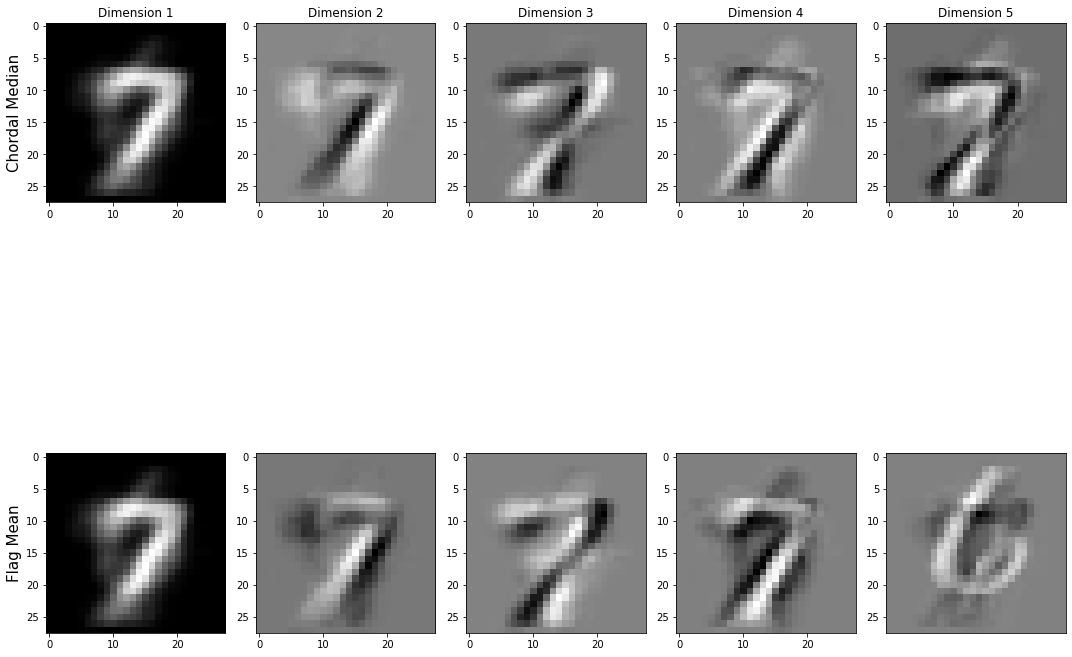

In [22]:
#8 examples of 6s

num_tests = num_samples2//incr
fig, axs = plt.subplots(2, 5, figsize=(15,15))

for ii in range(k):


    axs[0,ii].imshow(sin_medians[8][:,ii].reshape(28,28), cmap = 'gray')

    axs[1,ii].imshow(flagmeans[8][:,ii].reshape(28,28), cmap = 'gray')




plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelside=False) # labels along the bottom edge are off



cols = [ 'Dimension '+str(ii+1) for ii in range(k)]
rows = ['Chordal Median', 'Flag Mean']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)    


for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size = 15)
    

    
fig.tight_layout()
plt.show()

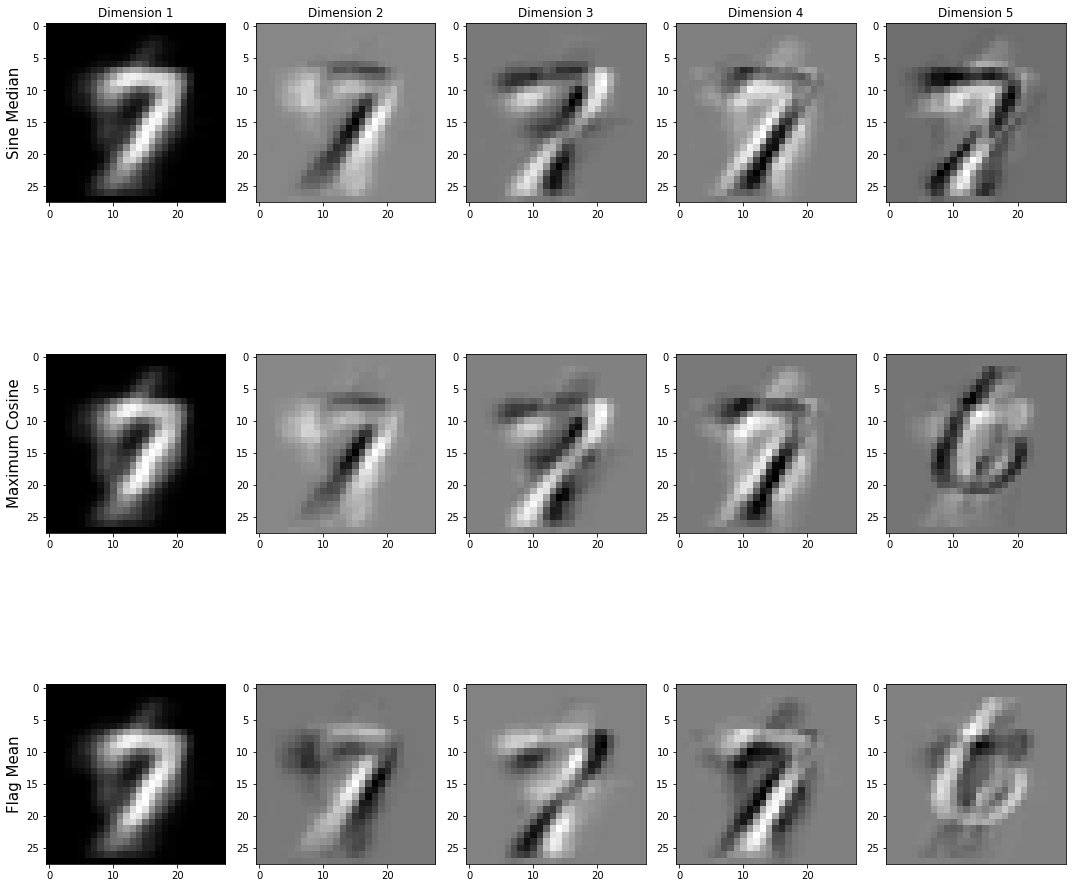

In [27]:
#8 examples of 6s

num_tests = num_samples2//incr
fig, axs = plt.subplots(3, 5, figsize=(15,15))

for ii in range(k):


    axs[0,ii].imshow(sin_medians[8][:,ii].reshape(28,28), cmap = 'gray')
    
    axs[1,ii].imshow(max_cosines[8][:,ii].reshape(28,28), cmap = 'gray')

    axs[2,ii].imshow(flagmeans[8][:,ii].reshape(28,28), cmap = 'gray')




plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelside=False) # labels along the bottom edge are off



cols = [ 'Dimension '+str(ii+1) for ii in range(k)]
rows = ['Sine Median', 'Maximum Cosine', 'Flag Mean']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)    


for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size = 15)
    

    
fig.tight_layout()
plt.show()